## Imports

In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MNIST_train = torchvision.datasets.MNIST("./data", train=True, download=True)
MNIST_test = torchvision.datasets.MNIST("./data", train=False, download=True)

x_train = MNIST_train.data.flatten(1).int() / 255
y_train = MNIST_train.targets.int()

x_test = MNIST_test.data.flatten(1).int() / 255
y_test = MNIST_test.targets.int()

In [3]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear4 = torch.nn.Linear(hidden_size, output_size)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.act(self.linear1(x))
        x = self.act(self.linear2(x))
        x = self.act(self.linear3(x))
        x = self.linear4(x)
        return x

In [4]:
dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [10]:
import time
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNetwork(784, 300, 10)
model = model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

start = time.time()
for epoch in range(num_epochs):
    b_x, b_y = next(iter(train_loader))
    b_x = b_x.float().to(device)
    b_y = b_y.long().to(device)
    output = model(b_x)
    loss = loss_fn(output, b_y)
    optimizer.zero_grad()
    #loss.backward()
    #optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {(output.argmax(1) == b_y).float().mean():.4f}")

print(f"Time: {time.time() - start:.2f} seconds")


Epoch 10/100, Loss: 2.3058, Accuracy: 0.0900
Epoch 20/100, Loss: 2.3131, Accuracy: 0.0700
Epoch 30/100, Loss: 2.3058, Accuracy: 0.1200
Epoch 40/100, Loss: 2.3095, Accuracy: 0.0800
Epoch 50/100, Loss: 2.2959, Accuracy: 0.1700
Epoch 60/100, Loss: 2.3012, Accuracy: 0.1000
Epoch 70/100, Loss: 2.3105, Accuracy: 0.0400
Epoch 80/100, Loss: 2.2951, Accuracy: 0.2000
Epoch 90/100, Loss: 2.3067, Accuracy: 0.0900
Epoch 100/100, Loss: 2.2937, Accuracy: 0.1800
Time: 0.47 seconds


## Test predictions for pre-trained

### Loading GPU and CPU weights and Biases

In [11]:
save_dir = "model_saves/"
names = ["w1", "w2", "w3", "w4", "b1", "b2", "b3", "b4"]
torch_names = ["linear1.weight", "linear2.weight", "linear3.weight", "linear4.weight", "linear1.bias", "linear2.bias", "linear3.bias", "linear4.bias"]
cpu_params ={}
gpu_params = {}

for reg_name, torch_name in zip(names, torch_names):
    gpu_param = np.loadtxt(save_dir + reg_name + "_gpu.csv", delimiter=",")
    cpu_param = np.loadtxt(save_dir + reg_name + "_cpu.csv", delimiter=",")
    gpu_params[torch_name] = torch.tensor(gpu_param.T)
    cpu_params[torch_name] = torch.tensor(cpu_param.T)



In [12]:
cpu_net = NeuralNetwork(784, 300, 10)
cpu_net.load_state_dict(cpu_params)

gpu_net = NeuralNetwork(784, 300, 10)
gpu_net.load_state_dict(gpu_params)

random_5_idx = np.random.choice(len(x_test), 8, replace=False)
x_in = x_test[random_5_idx].float()
y_in = y_test[random_5_idx].long()

cpu_out = cpu_net(x_in)
gpu_out = gpu_net(x_in)

cpu_pred = cpu_out.argmax(1)
gpu_pred = gpu_out.argmax(1)

## Printing predictions

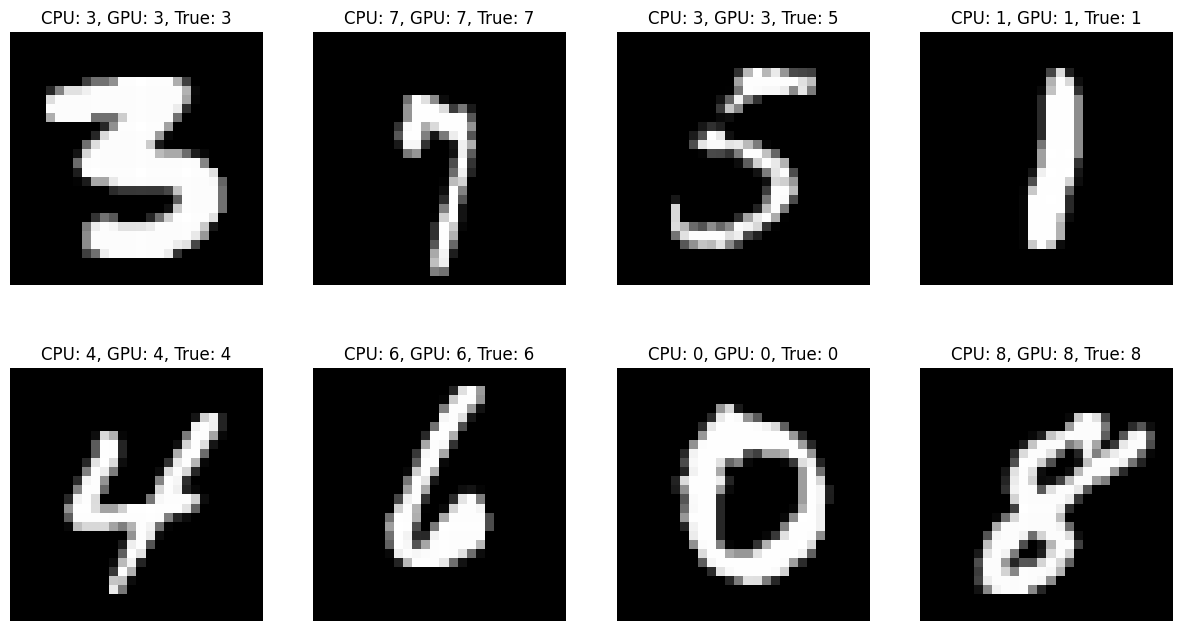

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))


for i in range(8):
    row = i // 4
    col = i % 4
    axs[row,col].imshow(x_in[row*4 + col].reshape(28, 28).cpu().numpy(), cmap='gray')
    axs[row,col].set_title(f"CPU: {cpu_pred[row*4+col].item()}, GPU: {gpu_pred[i].item()}, True: {y_in[i].item()}")
    axs[row,col].axis('off')

plt.show()

## Scaling Plots

In [14]:
shared_cpu = np.loadtxt("data/shared_cpu.csv", delimiter=",", comments="#")
shared_gpu = np.loadtxt("data/shared_gpu.csv", delimiter=",", comments="#")
dist_cpu   = np.loadtxt("data/dist_cpu.csv",   delimiter=",", comments="#")
dist_gpu   = np.loadtxt("data/dist_gpu.csv",   delimiter=",", comments="#")

## Plotting

### Shared CPU

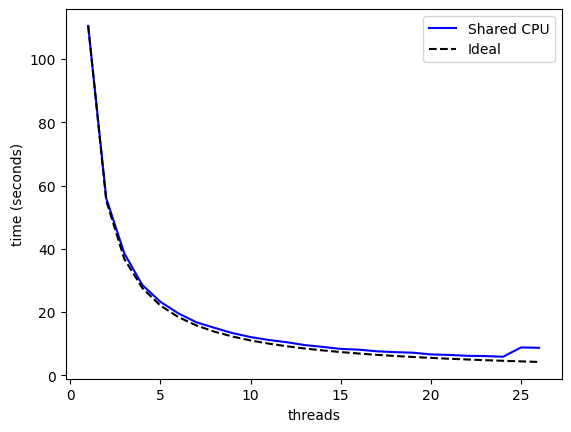

In [18]:
plt.plot(shared_cpu[:,0], shared_cpu[:,1], label="Shared CPU", color='blue')
plt.plot(shared_cpu[:,0], shared_cpu[0,1]/shared_cpu[:,0], label="Ideal", color='black', linestyle='--')
plt.xlabel("threads")
plt.ylabel("time (seconds)")
plt.legend()
plt.show()

### Shared GPU

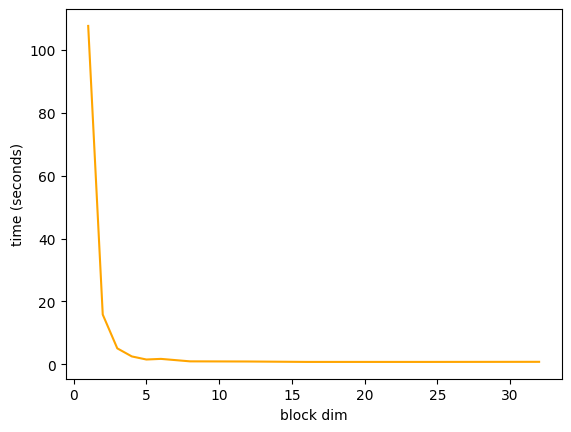

In [50]:
plt.plot(shared_gpu[:,0], shared_gpu[:,1], label="Shared GPU", color='orange')
plt.xlabel("block dim")
plt.ylabel("time (seconds)")
plt.show()


### Distributed CPU

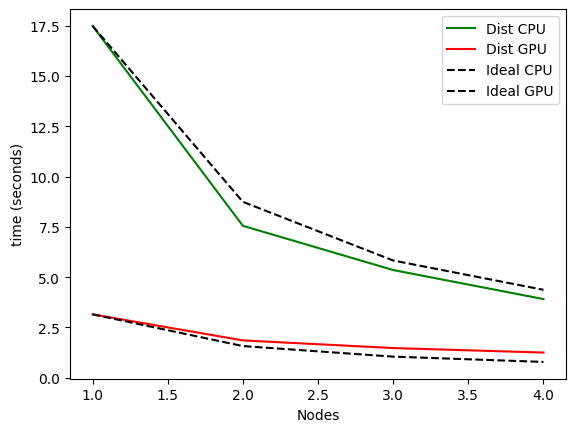

In [20]:
plt.plot(dist_cpu[:,0], dist_cpu[:,1], label="Dist CPU", color='green')
plt.plot(dist_gpu[:,0], dist_gpu[:,1], label="Dist GPU", color='red')
plt.plot(dist_cpu[:,0], dist_cpu[0,1]/dist_cpu[:,0], label="Ideal CPU", color='black', linestyle='--')
plt.plot(dist_gpu[:,0], dist_gpu[0,1]/dist_gpu[:,0], label="Ideal GPU", color='black', linestyle='--')
plt.xlabel("Nodes")
plt.ylabel("time (seconds)")
plt.legend()
plt.show()